#### Paper figures <a id='top'></a>

- [Figure 1](#figure1)
- [Figure 2](#figure2)
- [Figure 3](#figure3)
- [Figure 4](#figure4)
- [Figure 5](#figure5)

##### Package imports, figure settings, color definitions
<img src="color_pal.png" width="500">

/Users/mlanghinrichs/Documents/Studium/MSc/09_hiwi_hoefer/01_project/memo_py/memo_py/selection.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


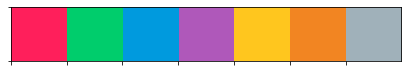

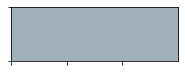

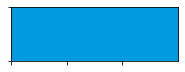

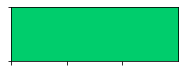

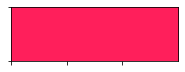

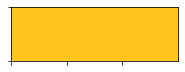

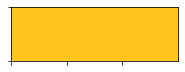

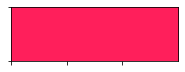

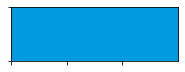

In [1]:
%matplotlib inline
%run settings_load.py

##### Waiting time functions
see settings_load.py

##### Cell hist and event functions
see settings_load.py

##### Figures -> all moved to specific notebooks